In [5]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import rasterstats 
import rasterio
from tqdm import tqdm

def read_shapefile(shapefile):
    gdf = gpd.GeoDataFrame.from_file(shapefile)
    gdf = gdf[gdf.geometry.notnull()]
    return gdf

def multi2single(gpdf):
    # reference: https://github.com/geopandas/geopandas/issues/369
    gpdf_singlepoly = gpdf[gpdf.geometry.type == 'Polygon']
    gpdf_multipoly = gpdf[gpdf.geometry.type == 'MultiPolygon']

    for i, row in gpdf_multipoly.iterrows():
        Series_geometries = pd.Series(row.geometry)
        df = pd.concat([gpd.GeoDataFrame(row, crs=gpdf_multipoly.crs).T]*len(Series_geometries), ignore_index=True)
        df['geometry']  = Series_geometries
        gpdf_singlepoly = pd.concat([gpdf_singlepoly, df])

    gpdf_singlepoly.reset_index(inplace=True, drop=True)
    return gpdf_singlepoly

work_dir = '/glade/u/home/hongli/work/research/discretization/optimize_hru/model'
input_dir = os.path.join(work_dir, 'input')
temp_dir = os.path.join(work_dir, 'temp')
output_dir = os.path.join(work_dir, 'output')
subfolder = 'intersect'
if not os.path.exists(os.path.join(temp_dir,subfolder)):
    os.makedirs(os.path.join(temp_dir,subfolder))

slp_shp = os.path.join(temp_dir, 'slp_class_raw.shp')
asp_shp = os.path.join(temp_dir, 'asp_class_raw.shp')
sub_shp = os.path.join(input_dir, 'subbasin_prj.shp')
elev_shp = os.path.join(input_dir, 'elev_class.shp')
land_shp = os.path.join(input_dir, 'land_class.shp')

raw_hru_shp = os.path.join(temp_dir,subfolder,'rawHRU.shp')
clean_hru_shp = os.path.join(temp_dir,subfolder,'HRU.shp')

sx_raster = '/glade/u/home/hongli/work/research/discretization/scripts/step7_merge_raw_Sx/sx.tif'
sw_raster = '/glade/u/home/hongli/work/research/discretization/scripts/step9_merge_raw_Sw/sw.tif'
dem_raster = '/glade/u/home/hongli/work/research/discretization/optimize_hru/model/input/dem_buf_100m.tif'

# # # # -------------------------------Part 1. Reclassify--------------------------------------
# print('Part 1. Resolve')
# # slp_class_raster=os.path.join(temp_dir, 'slp_class.tif')
# # slp_file=os.path.join(temp_dir, 'slp_class')
# # os.system("gdal_calc.py -A ${slp_file} --outfile=${slp_class_raster} --calc="1*((A>=0)*(A<=${slp_thrsh1}))+2*((A>${slp_thrsh1})*(A<=${slp_thrsh2}))+3*((A>${slp_thrsh2})*(A<=${slp_thrsh3}))+4*((A>${slp_thrsh3})*(A<=79))" --NoDataValue=${nodata} --quiet")
# # os.system("gdal_polygonize.py ${slp_class_raster} -f "ESRI Shapefile" ${slp_raw_shp}.shp") "" "slope"")

# asp_class_raster=os.path.join(temp_dir, 'asp_class.tif')
# asp_raw_shp=os.path.join(temp_dir, 'asp_class_raw.shp')
# asp_shp=os.path.join(temp_dir, 'asp_class.shp')

# # resolve raw class shapefile
# g_asp = read_shapefile(asp_raw_shp)
# g_asp['geometry'] = g_asp.geometry.buffer(0)
# g_asp = g_asp.dissolve(by='aspect') 
# g_asp.to_file(asp_shp)


# # # -------------------------------Part 1. Intersect--------------------------------------
print('Part 1. Intersect')

# read shapefiles
g_sub = read_shapefile(sub_shp)
g_slp = read_shapefile(slp_shp)
g_asp = read_shapefile(asp_shp)
g_elev = read_shapefile(elev_shp)
g_land = read_shapefile(land_shp)

# intersection
df = g_sub[['HUC12', 'geometry']]
# for gdf in [g_slp, g_asp, g_elev, g_land]:
#     df = gpd.overlay(df, gdf, how='intersection')

# df['HRU'] = None # add HRU column
# for var in ['HUC12','slope','aspect','elevation','land']:
#     df[var]=df[var].astype(str)
# df['HRU']=df['HUC12']+'_slp'+df['slope']+'_asp'+df['aspect']+'_elev'+df['elevation']+'_land'+df['land']

for gdf in [g_slp, g_asp]:
    df = gpd.overlay(df, gdf, how='intersection')

df['HRU'] = None # add HRU column
for var in ['HUC12','slope','aspect']:
    df[var]=df[var].astype(str)
df['HRU']=df['HUC12']+'_slp'+df['slope']+'_asp'+df['aspect']

# for i in range(len(df)):
#     df.loc[i,'HRU']=df.loc[i,'HUC12']+'_slp'+str(df.loc[i,'slope'])+'_asp'+str(df.loc[i,'aspect'])+'_elev'+str(df.loc[i,'elevation'])+'_land'+str(df.loc[i,'land'])

# # dissolve based on HRU column
# df['geometry'] = df.geometry.buffer(0)
# df = df.dissolve(by='HRU') 

df['Area'] = df.area # add area column
df.to_file(raw_hru_shp) # save 

# # ##-------------------------------Part 2. Eliminate--------------------------------------
# print('Part 2. Eliminate')

# df = read_shapefile(raw_hru_shp)  

# print('(1) buffer intershection if needed')
# # count = 0
# # for index, row in df.iterrows():
# #     if not row['geometry'].is_valid:
# # #         print('invalid hruId = '+str(index))  
# #         clean = row['geometry'].buffer(0)
# #         if not clean.is_valid:
# #             count=count+1
# # if count==0:    
# #     df['geometry'] = df.geometry.buffer(0)
# df['geometry'] = df.geometry.buffer(0)

# print('(2) calculate HRU area threshold')
# total_area = np.sum(df['Area'])
# thrsh = 0.01
# thrsh_area = total_area*thrsh

# print('(3) eliminate and dissolve small HRUs')
# # # method 1: change HRU attribute to the most dominate HRU
# # df['NewHRU'] = df['HRU'] # add column with filled HRU by default
# # locs=np.where(df['Area']<thrsh_area)[0]
# # for i in locs:
# #     df.loc[i,'NewHRU'] = dominant_hru
    
# # method 2: change HRU attribute to its' largest neighbor's HRU
# df2 = df
# elim_df = df2[df2['Area']<thrsh_area]
# dominant_hru_index = np.argmax(df2['Area'].values) # the most dominate HRU index
# dominant_hru = df2.loc[dominant_hru_index,'HRU'] # the most dominate HRU attribute

# row_num = len(df2)  # total number of HRUs
# elim_num = len(np.where(df2['Area']<thrsh_area)[0]) # number of to-be eliminated HRUs
# iter_num = 0 # iteration number

# while row_num>1 and elim_num != 0 and iter_num<10:
#     print('Iteration ', iter_num,'. Target ',elim_num,'/',row_num,' HRUs.',)
    
#     pbar = tqdm(total=elim_num)
#     for index, row in elim_df.iterrows(): #single_df.iterrows():  

#         index_df2 = np.where(df2['HRU'].values==elim_df.loc[index,'HRU'])[0]

#         # identify neighbours
#         if not row['geometry'].is_valid:
#             print('buffer')
#             clean = row['geometry'].buffer(0)
#             neighbors_index = df2[df2.geometry.touches(clean)].index.tolist() # find each polygon's neighbouring polygons
#         else:
#             neighbors_index = df2[df2.geometry.touches(row['geometry'])].index.tolist() # find each polygon's neighbouring polygons

#         # update NewHRU
#         if len(neighbors_index)>0:
#             neighbors_area = [df2.loc[i,'Area'] for i in neighbors_index]
#             max_neighbor_index = neighbors_index[neighbors_area.index(max(neighbors_area))] 
#             df2.loc[index_df2,'HRU'] = df2.loc[max_neighbor_index,'HRU'] # take the max-area neighbor HRU's attribute
#         else:
#             print('no neighbors')
#             df2.loc[index_df2,'HRU'] = dominant_hru # take the most dominant HRU's attribute

#         pbar.update(1)
#     pbar.close()

#     df2 = df2.dissolve(by='HRU') # dissolve based on HRU column
#     df2 = df2.reset_index() # change HRU from index to column

#     df2['geometry'] = df2.geometry.buffer(0)
#     df2['Area'] = df2.area # update area
#     elim_df = df2[df2['Area']<thrsh_area] # update to-be eliminated HRUs
#     print('--> Eliminate ',elim_num-len(np.where(df2['Area']<thrsh_area)[0]),' HRUs.')

#     dominant_hru_index = np.argmax(df2['Area'].values) # udpate the most dominate HRU index
#     dominant_hru = df2.loc[dominant_hru_index,'HRU'] # udpate the most dominate HRU attribute

#     row_num = len(df2) # udpate total number of HRUs
#     elim_num = len(np.where(df2['Area']<thrsh_area)[0]) # udpate number of to-be eliminated HRUs
#     iter_num = iter_num+1 # udpate iteration number

# print('(4) save')
# df2.to_file(clean_hru_shp) 

# ##-------------------------------Part 3. Zonal statistics--------------------------------------
# print('Part 3. Zonal statistics')

# df = read_shapefile(clean_hru_shp) # read HRU shapefile
# df.to_crs(crs=raster.crs.data)

# raster_files = [sx_raster,sw_raster]
# var_names = ['sx','sw']
# for i in range(len(var_names)):
    
#     var_name = var_names[i]
#     raster_file = raster_files[i]
#     print(var_name)
    
#     raster = rasterio.open(raster_file) # read raster shapefile
#     array = raster.read(1)
#     affine = raster.affine

#     dicts = rasterstats.zonal_stats(df, array, affine=affine, stats=['mean'])
#     df[var_name]=np.asarray([dicts[i]['mean'] for i in range(len(dicts))])

# df.to_file(clean_hru_shp)
# df[['HRU','Area','sx','sw']].to_csv(clean_hru_shp.replace('.shp','.csv'))

print('Done')

Part 1. Intersect


KeyboardInterrupt: 

In [82]:
a=np.asarray([dicts[i]['mean'] for i in range(len(dicts))])

In [83]:
df['sx']=a

In [85]:
df

,HRU,HUC12,slope,aspect,elevation,land,Area,geometry,sx
0,140500010101_slp1_asp1_elev3250_land42,140500010101,3,1,3500,30,3.001936e+06,(POLYGON ((323202.6404910814 4434732.533679893...,14.990625
1,140500010101_slp1_asp1_elev3500_land42,140500010101,1,1,3500,42,1.201128e+06,(POLYGON ((322542.1708278961 4437016.782300493...,10.570154
2,140500010101_slp1_asp1_elev3500_land50,140500010101,2,1,3500,30,1.268618e+06,(POLYGON ((322432.0925506985 4432378.267259323...,10.171450
3,140500010101_slp1_asp2_elev3250_land42,140500010101,2,2,3250,70,1.951836e+06,"(POLYGON ((323175.120921782 4434044.506986941,...",12.759361
4,140500010101_slp1_asp2_elev3500_land42,140500010101,1,2,3500,42,1.304771e+06,(POLYGON ((322569.6903971955 4436989.261232775...,11.979878
5,140500010101_slp1_asp2_elev3500_land50,140500010101,1,3,3500,30,5.052843e+06,"(POLYGON ((322795.7304457166 4435200.3918311, ...",16.940730
6,140500010101_slp1_asp3_elev3250_land40,140500010101,1,3,3000,50,1.297176e+06,(POLYGON ((321991.7794419083 4435145.349695664...,10.413658
7,140500010101_slp1_asp3_elev3250_land42,140500010101,2,3,3250,70,1.502669e+06,(POLYGON ((322597.2099664949 4435764.672243429...,9.866461
8,140500010101_slp1_asp3_elev3250_land50,140500010101,2,3,3250,30,9.380717e+05,(POLYGON ((323092.5622138839 4434801.566238776...,10.458302
9,140500010101_slp1_asp3_elev3500_land42,140500010101,1,3,3500,42,1.721577e+06,(POLYGON ((322597.2099664949 4437016.782300493...,9.010461


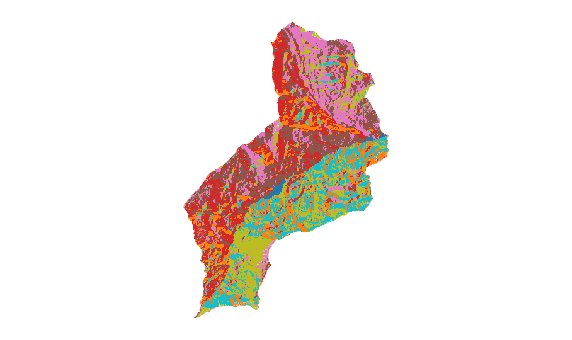

In [60]:
# create the plot
fig, ax = plt.subplots(figsize = (10,6))

# plot the data 
single_df.reset_index().plot(column = 'slope', ax=ax)

# Set plot axis to equal ratio
ax.set_axis_off()
plt.axis('equal');